<a href="https://colab.research.google.com/github/sidharkal/AIorNOT-by-Hugging-Face/blob/main/Ai_or_Not_Efficient%20B3%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip Data Files

In [1]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Huggingface /Ai NotAI/train.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Huggingface /Ai NotAI/test.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

# Import Librery

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from keras import backend as K
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Load the Data File

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Huggingface /Ai NotAI/train.csv',dtype={'label': str})
sample =  pd.read_csv('/content/sample_submission.csv',dtype={'label': str})
train.head()

,id,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18618 entries, 0 to 18617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18618 non-null  object
 1   label   18618 non-null  object
dtypes: object(2)
memory usage: 291.0+ KB


In [6]:
train.shape,sample.shape

((18618, 2), (43442, 2))

In [7]:
train['label'].value_counts()

1    10330
0     8288
Name: label, dtype: int64

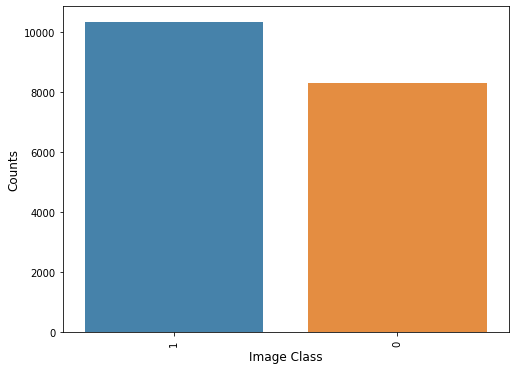

In [8]:
label_counts = train.label.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

# Import Data From DataFrame

In [9]:
src_path_train = "/content/train/"
src_path_test = "/content/test/"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [10]:
batch_size = 32
IMAGE_SHAPE = (300, 300)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="id",
    y_col="label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="id",
    y_col="label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample,
    directory=src_path_test,
    x_col="id",
    target_size=(300, 300),
    batch_size=16,
    class_mode=None,
    shuffle=False,
)

Found 14895 validated image filenames belonging to 2 classes.
Found 3723 validated image filenames belonging to 2 classes.
Found 43442 validated image filenames.


# Visualize Sample Data

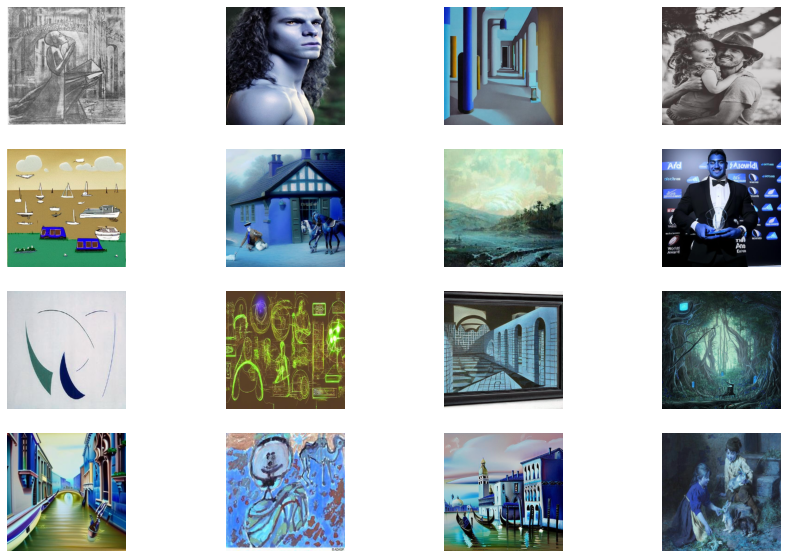

In [11]:
rand_images = random.sample(os.listdir(src_path_train), 16)

fig = plt.figure(figsize=(15,10))
for i, im in enumerate(rand_images):
    plt.subplot(4,4, i+1)
    im = cv2.imread(os.path.join(src_path_train, im))
    im = cv2.resize(im, (300,300))
    plt.imshow(im)
    plt.axis('off')
    
plt.show()

# Efficient B3 Model

In [12]:
# Original: EfficientNetB3 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"

def create_model(model_url, num_classes=1):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,                  # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape= IMAGE_SHAPE+(3,))    # define the input image shape
  
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
      ])
    return model

# Compile the Model

In [13]:
# Create model
model = create_model(model_url=efficientnet_url,num_classes=1)

# Compile EfficientNet model
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Fit The Model

In [14]:
# fit the model
history = model.fit(train_generator,
                    epochs=7,
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,   
                    validation_steps=len(valid_generator)) 

Epoch 1/7
466/466 [==============================] - 498s 1s/step - loss: 0.3443 - accuracy: 0.8575 - val_loss: 0.2740 - val_accuracy: 0.8883
Epoch 2/7
466/466 [==============================] - 454s 974ms/step - loss: 0.2718 - accuracy: 0.8892 - val_loss: 0.2571 - val_accuracy: 0.8923
Epoch 3/7
466/466 [==============================] - 456s 978ms/step - loss: 0.2513 - accuracy: 0.8967 - val_loss: 0.2452 - val_accuracy: 0.8931
Epoch 4/7
466/466 [==============================] - 468s 1s/step - loss: 0.2398 - accuracy: 0.9022 - val_loss: 0.2382 - val_accuracy: 0.8977
Epoch 5/7
466/466 [==============================] - 462s 991ms/step - loss: 0.2339 - accuracy: 0.9061 - val_loss: 0.2344 - val_accuracy: 0.9046
Epoch 6/7
466/466 [==============================] - 462s 992ms/step - loss: 0.2299 - accuracy: 0.9084 - val_loss: 0.2354 - val_accuracy: 0.9038
Epoch 7/7
466/466 [==============================] - 465s 997ms/step - loss: 0.2253 - accuracy: 0.9092 - val_loss: 0.2415 - val_accuracy

# Accuracy 

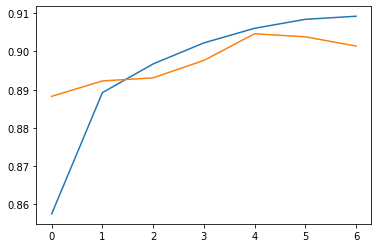

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Loss

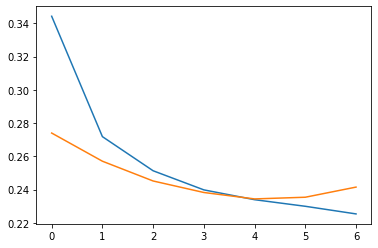

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Validate on Validation Data

In [17]:
score = model.evaluate_generator(valid_generator)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23712050914764404
Test accuracy: 0.9030351638793945


# Test Data

In [18]:
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))

In [19]:
predict[:5]

array([[0.50320894],
       [0.33166623],
       [0.00160742],
       [0.47534752],
       [0.722553  ]], dtype=float32)

In [20]:
prediction = [i[0] for i in predict]

In [21]:
# make submission
submission = pd.DataFrame({'id':sample['id'], 'label':prediction})
submission.to_csv('submission.csv', index=False)

In [22]:
submission.head()

,id,label
0,0.jpg,0.503209
1,1.jpg,0.331666
2,10.jpg,0.001607
3,100.jpg,0.475348
4,1000.jpg,0.722553
